# Approximate Bayesian Computation

In [1]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra,CSV, Random
using LaTeXStrings
using SymPy
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

## Discrete Example

In [2]:
n, x = 8, 6
N = 3_000

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

aux = sort(DataFrame(x1 = z, x2 = theta_s),:x2)
z       = aux[!,:x1]
theta_s = aux[!,:x2];

In [3]:
# k = collect(0:1:n)
# beta_distributions = pdf.(Beta.(x.+k',n .- k' .+1),v);
# plot(v,beta_distributions)

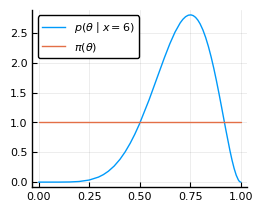

In [4]:
# histogram(theta_a,normalize=true,alpha=0.5)
plot(Beta(x+1,n-x+1),label=L"p(\theta \mid x=6)")
p = plot!(Beta(1,1), label =L"\pi(\theta)",size = (250, 200))
savefig(p,"./vis-project/static/images/distributions.png")

In [5]:
cm = countmap(z)
counter = zeros(length(cm))
hdots = zeros(N)
for (i,v) in enumerate(z)
    counter[v+1]+=1
    hdots[i] = counter[v+1]
end


df = DataFrame([z,hdots,theta_s,collect(1:length(z))]);

In [6]:
CSV.write("./ABC/data/ABC_Beta.csv",df)

"./ABC/data/ABC_Beta.csv"

WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window


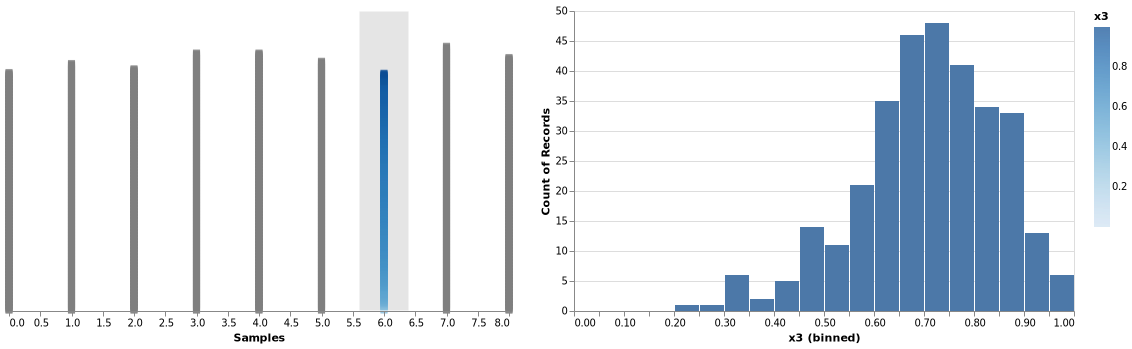

In [7]:
points = df |> vl"""
{
"hconcat" : [
  {
    "view":{"stroke" : null},
    "layer": [{

    
    "selection": {
      "brush": {"type": "interval","encodings": ["x"],"init":{"x": [5.6, 6.4]}}
    },
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": {"type": "square"},
    "encoding": {
        "x": {"field": "x1", "type": "quantitative","axis": {"grid":false, "title":"Samples"}},
        "y": {"field": "x2", "type": "quantitative", "axis": null},
        "size":{"value":50},
        "color": {
              "condition": {"selection": "brush", "field": "x3", "type": "quantitative"},
              "value": "grey"
            }
        }
}]},
  {
    "layer":[{
    "transform": [
      {"filter": {"selection": "brush"}}
    ],
    "width": 500,
    "height": 300,
    "mark": "bar",
    "encoding": {
    "x": {
        "bin":{"maxbins":20},
        "field": "x3",
        "type": "quantitative"
    },
    "y": {
        "aggregate": "count",
        "type": "quantitative"
      }
    }}
    ]
}]
}
"""

In [10]:
# VegaLite.savespecpec("./ABC/data/ABC_Beta.vegalite", points)

## Continuos Example 

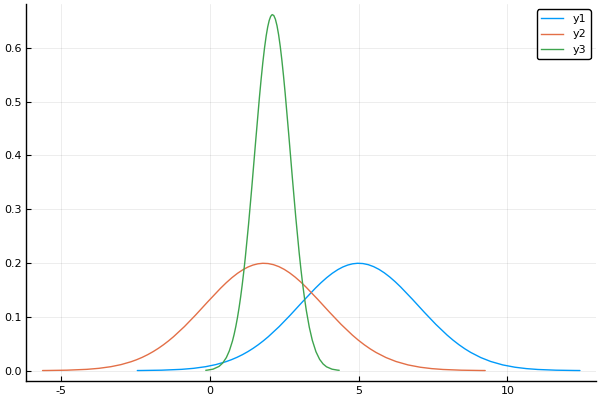

In [276]:
θ = 5.0
σ = 2.0
n = 10
Random.seed!(38);
y = rand(Normal(θ,σ),n) .-3
μ = mean(y)
τ = 2.0
μ1= (μ*n*(1/τ^2) + θ*(1/σ^2))/(n*(1/τ^2)+(1/σ^2))
τ1= sqrt(1/(n*(1/τ^2)+(1/σ^2)))
plot(Normal(θ,σ))
plot!(Normal(μ,τ))
plot!(Normal(μ1,τ1))

In [277]:
N    = (10^6)
θabc = rand(Normal(θ,σ),N)
z    = rand.(Normal.(θabc,σ),n);
zmean= mean.(z);
rawdistance(z) = sum((z .- y).^2)
ρ_raw   = rawdistance.(z) # Raw Disance
ρ_mean  = (zmean .- mean(y)).^2;

In [278]:
ϵ_raw  = quantile(ρ_raw,0.001)
ϵ_mean = quantile(ρ_mean,0.001)

6.53392098963649e-5

In [279]:
θabc_raw  = θabc[ρ_raw .<= ϵ_raw]
θabc_mean = θabc[ρ_mean .<= ϵ_mean];

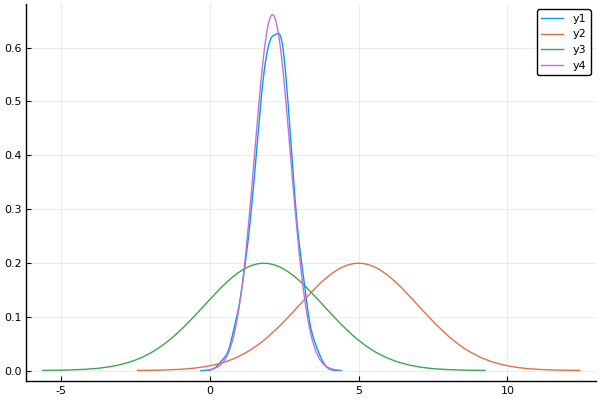

In [285]:
density(θabc_mean,normalize=true)
plot!(Normal(θ,σ))
plot!(Normal(μ,τ))
plot!(Normal(μ1,τ1))

In [287]:
?density

search: density density! cdensity cdensity! DimensionMismatch



```
density(x)
density!(x)
```

Make a line plot of a kernel density estimate of x.

# Arguments

  * `x`: AbstractVector of samples for probability density estimation

# Example

```julia-repl
julia> using StatsPlots
julia> density(randn(100_000))
```
